# Setup/Imports

In [47]:
%%capture
from src.drops import Drops

drop_model = Drops(
    file_path="../data/2023-05-20_nationals_c.yaml", method="std_deviation", alpha=2.5
)

The code for the [`Drops`](../src/drops.py) class subclasses [`Results`](../utils/results.py) and is shown below:
```python
class Results:
    ...
    @property
    def teams(self) -> list[int]:
        ...
    @property
    def teams_data(self) -> list[dict[str, str | int]]:
        ...
    @property
    def events(self) -> list[str]:
        ...
    @property
    def trial_events(self) -> list[str]:
        ...
    @property
    def score_sum(self) -> dict[int, int]:
        ...
    @property
    def full_scores(self) -> dict[int, list[int]]:
        ...
    @property
    def averages(self) -> dict[int, float]:
        ...

```
```python
class Drops(Results):
    ...
    def iqr(self, alpha: float = ...) -> None:
        """Calculates the IQR method for determining "bombed" events"""
        ...
    def mean(self, alpha: float = ...) -> None:
        """Calculates the mean method for determining "bombed" events"""
        ...
    def std_deviation(self, alpha: float = ...) -> None:
        """Calculates the standard deviation method for determining "bombed" events"""
        ...
    def drop(self) -> None:
        """Drops the "bombed" events from the scores"""
        ...
    def visualize(self) -> None:
        """Visualizes the data"""
        ...
    
```

## Average Score Per School

In [48]:
import utils

print(
    "Average score per school: ",
    utils.pretty_print(
        drop_model.teams,
        dict(sorted(drop_model.averages.items(), key=lambda item: item[1])),
    ),
)

Average score per school:  {'Adlai E. Stevenson High School ': 9.043478260869565, 'Solon High School ': 9.91304347826087, 'Mason High School ': 10.130434782608695, 'Troy High School ': 12.130434782608695, 'Harriton High School ': 12.73913043478261, 'Acton-Boxborough Regional High School ': 12.956521739130435, 'Castro Valley High School ': 13.956521739130435, 'Seven Lakes High School ': 14.173913043478262, 'New Trier High School ': 14.478260869565217, 'William G. Enloe High School ': 15.956521739130435, 'Marquette University High School ': 16.08695652173913, 'Syosset High School ': 16.565217391304348, 'Grand Haven High School ': 17.608695652173914, 'Lower Merion High School ': 18.130434782608695, 'West Windsor-Plainsboro High School North ': 18.391304347826086, 'William P. Clements High School ': 20.08695652173913, 'North Carolina School of Science and Mathematics ': 20.434782608695652, 'Carmel High School ': 20.434782608695652, 'Ward Melville High School ': 20.73913043478261, 'F.W. Buc

# Distinguishing "Bombed" Events
### Using the following methods to determine "bombed" events:
##### These values become the upper fence for the data
- [$\alpha \times \overline{X} $](../src/drops.py#L38)
- [$\alpha \times (Q_3 - Q_1) + Q_3$ &nbsp; (IQR)](../src/drops.py#L30)
- [$\alpha \times \sigma + \overline{X} $&nbsp;&nbsp;&nbsp; (Standard Deviation)](../src/drops.py#L44)

where $\alpha$ is a multiplicative constant. 
##### We then take the $\sum_n^k{b_n}$ (sum of all "bombed" events) and divide by $T$ (number of teams) to get the average number of "bombed" events per team. 

### Mean Method (alpha = 2)

In [49]:
%%capture
# redefine our model to use this method
mean_model = Drops(
    file_path="../data/2023-05-20_nationals_c.yaml", method="mean", alpha=2
)
mean_model.drop()

### IQR Method (alpha = 1.5, standard outlier formula)

In [50]:
%%capture
# redefine our model to use this method
iqr_model = Drops(
    file_path="../data/2023-05-20_nationals_c.yaml", method="iqr", alpha=1.5
)
iqr_model.drop()

### Standard Deviation Method (alpha = 1.5)

In [51]:
%%capture
# redefine our model to use this method
std_dev_model = Drops(
    file_path="../data/2023-05-20_nationals_c.yaml", method="std_deviation", alpha=1.5
)
std_dev_model.drop()

## Consistent Flaws
All of these methods are too sensitive to "top" teams while do not account nearly as well for lower ranked teams. A possible solution would be a scalar multiplier based on the team's rank. This would have a greater account for bombs even when the mean/median place on a team is lower. 

## Calculating Bombed Events
Using the standard deviation method with $\alpha = 1.5$ to determine "bombed" events as a demonstration


In [52]:
%%capture
std_dev_model = Drops(
    file_path="../data/2023-05-20_nationals_c.yaml", method="std_deviation", alpha=1.5
)

std_dev_model.drop()

In [53]:
for school, events in std_dev_model.bombed_events.items():
    print(f"{std_dev_model.teams[school]}: {', '.join(events) if events else 'None'}")

Syosset High School : Bridge, Flight, Remote Sensing
Ward Melville High School : Environmental Chemistry
Troy High School : Chemistry Lab, Forensics, WiFi Lab, Write It Do It
Castro Valley High School : Scrambler
William G. Enloe High School : Astronomy, Scrambler
North Carolina School of Science and Mathematics : Environmental Chemistry, Forensics
Grand Haven High School : Chemistry Lab, Detector Building
Pioneer High School : Anatomy and Physiology, Write It Do It
Harriton High School : Detector Building, Dynamic Planet, Fermi Questions
Lower Merion High School : Remote Sensing
Adlai E. Stevenson High School : Experimental Design, Trajectory
New Trier High School : Experimental Design, Scrambler
F.W. Buchholz High School : Experimental Design, Write It Do It
Boca Raton Community High School : Environmental Chemistry
Solon High School : Experimental Design, Remote Sensing
Mason High School : Trajectory
Seven Lakes High School : Bridge
William P. Clements High School : Forensics, Scram

## Recalculating scores/ranking with auto drop "bombed" events
### Dropping $\lfloor{\frac{\sum_n^k{b_n}}{T}}\rfloor$ (avg) "bombed" events from each team's scores

In [54]:
print(f"After dropping {std_dev_model.to_drop} events:")
for i, (t_number, score) in enumerate(std_dev_model.dropped_scores.items()):
    print(f"{i+1}. {std_dev_model.teams[t_number]}: {score}")

After dropping 1 events:
1. Adlai E. Stevenson High School : 184
2. Solon High School : 192
3. Mason High School : 193
4. Acton-Boxborough Regional High School : 248
5. Troy High School : 252
6. Harriton High School : 262
7. Castro Valley High School : 270
8. Seven Lakes High School : 281
9. New Trier High School : 283
10. Syosset High School : 328
11. William G. Enloe High School : 330
12. Marquette University High School : 337
13. Grand Haven High School : 360
14. Lower Merion High School : 376
15. West Windsor-Plainsboro High School North : 383
16. William P. Clements High School : 414
17. North Carolina School of Science and Mathematics : 416
18. Carmel High School : 419
19. Ward Melville High School : 438
20. F.W. Buchholz High School : 449
21. duPont Manual High School : 454
22. Pioneer High School : 487
23. Ladue Horton Watkins High School : 490
24. Centennial High School : 490
25. Brookwood High School : 514
26. Thomas Jefferson High School for Science and Technology : 518
27. 

# Visualization of Data
We can see overall placement changes between teams as well as an overall trend as to how dropping affects the shape of the relationship/curve between teams and their scores.

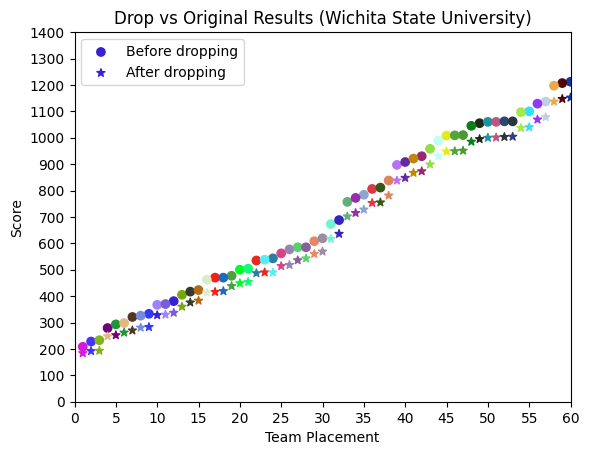

In [55]:
std_dev_model.visualize()